
본 파일은 이기창님의 'Do it! 자연어 처리'에 기초하여 작성되었음을 미리 알려드립니다! :)

# 학습 마친 모델을 실전 투입하기

학습을 마친 문장 쌍 분류 모델을 인퍼런스하는 과정을 실습해본다. 이번 실습에서 만드는 웹 서비스의 개념도는 아래 그림 1과 같다.

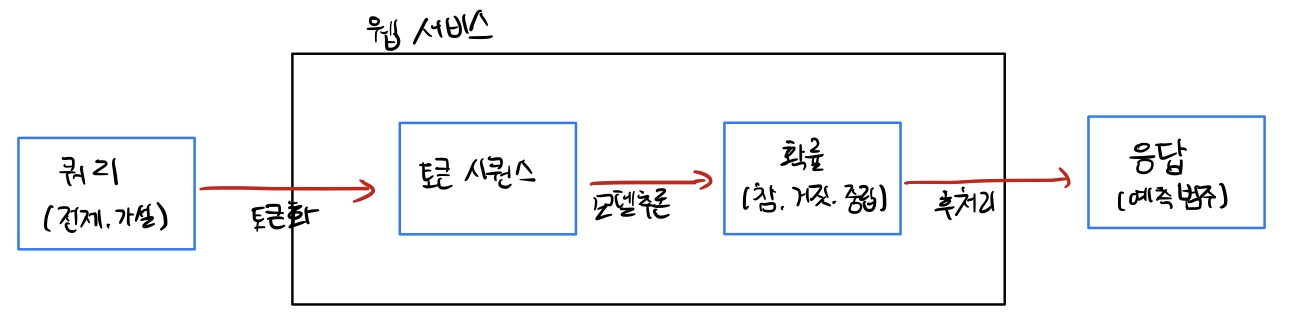

**그림 1.** 문장 쌍 분류 웹 서비스

전제와 가설 문장을 받아 답변하는 웹 서비스이다. 전제와 가설 각각을 토큰화, 인덱싱한 뒤 모델 입력값으로 만들고 이를 모델에 넣어 

**[전제에 대해 가설이 참일 확률, 전제에 대해 가설이 거짓일 확률, 전제에 대해 가설이 중립일 확률]**
을 계산한다.

이후 약간의 후처리 과정을 거쳐 응답하는 방식이다.

# 전제와 가설을 검증하는 웹 서비스 만들기

## 1. 환경 설정하기

### 의존성 패키지 설치

pip 명령어를 통해 의존성있는 패키지를 설치한다.

#### code 4-0

In [1]:
!pip install ratsnlp

### 구글 드라이브 연동

학습한 모델의 체크포인트는 구글 드라이브에 저장해 두었으므로, code 4-1을 실행하여 코랩 노트북과 자신의 구글 드라이브를 연동한다.

#### code 4-1

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


### 인퍼런스 설정

각종 인퍼런스 설정을 수행한다. `pretrained_model_name`과 `max_seq_length`, `downstream_model_dir` 모두 앞 트레인에서 적용한 그대로 입력하여야 한다.

#### code 4-2

In [3]:
from ratsnlp.nlpbook.classification import ClassificationDeployArguments
args = ClassificationDeployArguments(
    pretrained_model_name="beomi/kcbert-base",
    downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-paircls",
    max_seq_length=64,
)

downstream_model_checkpoint_fpath: /gdrive/My Drive/nlpbook/checkpoint-paircls/epoch=1-val_loss=0.82.ckpt


## 2. 토크나이저 및 모델 불러오기

### 토크나이저 로드

code 4-3을 실행해 토크나이저를 초기화한다.

#### code 4-3

In [4]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    args.pretrained_model_name,
    do_lower_case=False,
)

### 체크포인트 로드

code 4-4는 `pair_classification_train.ipynb`에서 파인튜닝한 모델의 체크포인트를 읽어 들인다.

#### code 4-4

In [5]:
import torch
fine_tuned_model_ckpt = torch.load(
    args.downstream_model_checkpoint_fpath,
    map_location=torch.device("cpu"),
)

### BERT 설정 로드 및 BERT 모델 초기화

code 4-5는 `pair_classification_train.ipynb`의 파인튜닝 때 사용한 `pretrained_model_name`에 해당하는 모델의 설정값들을 읽어들이며, code 4-6을 실행하면 해당 값대로 BERT 모델을 초기화 한다.

#### code 4-5

In [6]:
from transformers import BertConfig
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels=fine_tuned_model_ckpt['state_dict']['model.classifier.bias'].shape.numel(),
)

#### code 4-6

In [7]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification(pretrained_model_config)

### 체크포인트 주입하기

code 4-7은 초기화한 **BERT**모델에 code 4-4의 체크포인트를 주입한다

#### code 4-7

In [8]:
model.load_state_dict({k.replace("model.",""): v for k, v in fine_tuned_model_ckpt['state_dict'].items()})

<All keys matched successfully>

### 평가 모드로 전환

이어서 code 4-8을 실행하면 모델이 평가모드로 전환되게 된다. **드롭아웃 등 학습 때만 사용하는 기법들을 무효화하는 역할**을 한다.

#### code 4-8

In [9]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 3. 모델 출력값 만들고 후처리 하기

code 4-9는 **인퍼런스 과정을 정의한 함수**이다. 전제(premise)와 가설(hypothesis)을 입력받아 각각 토큰화, 인덱싱을 수행한 뒤 `input_ids`, `attention_mask`, `token_type_ids`를 만든다. 이들 압력값을 파이토치 텐서 자료형으로 변환한 뒤 모델에 입력한다.

### 인퍼런스 함수

#### code 4-9

In [10]:
def inference_fn(premise, hypothesis):
  # 전제와 가설을 모델 입력값으로 만들기
  inputs = tokenizer(
      [(premise, hypothesis)],
      max_length=args.max_seq_length,
      padding="max_length",
      truncation=True,
  )
  with torch.no_grad():
    # 모델 계산하기
    outputs = model(**{k: torch.tensor(v) for k, v in inputs.items()})  # {}안 = inputs를 파이토치 텐서로 바꾸기

    # 로짓에 소프트맥스 취하기
    prob = outputs.logits.softmax(dim=1)

    # 확률을 소수점 두 자리에서 반올림
    entailment_prob = round(prob[0][0].item(), 2)
    contradiction_prob = round(prob[0][1].item(), 2)
    neutral_prob = round(prob[0][2].item(), 2)

    # 예측 확률의 최댓값 위치에 따라 pred 만들기
    if torch.argmax(prob) == 0:
      pred = "참 (entailment)"
    elif torch.argmax(prob) == 1:
      pred = "거짓 (contradiction)"
    else:
      pred = "중립 (neutral)"
  
  return {
      'premise': premise,
      'hypothesis': hypothesis,
      'prediction': pred,
      'entailment_data': f"참 {entailment_prob}",
      'contradiction_data': f"거짓 {contradiction_prob}",
      'neutral_data': f"중립 {neutral_prob}",
      'entailment_width': f"{entailment_prob * 100}%",
      'contradiction_width': f"{contradiction_prob * 100}%",
      'neutral_width': f"{neutral_prob * 100}%"
  }

**모델 출력값(`output.logits`)**은 소프트맥스 함수 적용 이전의 로짓 형태이다. 여기에 소프트맥스 함수를 써서 모델 출력을 확률 형태로 바꾼다. 그리고 약간 후처리하여 예측 확률의 최댓값이 참 위치(0)일 경우 해당 문장이 '**참 (entailment)**', 거짓 위치(1)일 경우 '**거짓 (contradiction)**', 중립 위치(2)일 경우 '**중립 (neutral)**'이 되도록 pred 값을 만든다.

code 4-9에서 `entailment_width`, `contradiction_width`, `neutral_width`는 웹 페이지에서 참, 거짓, 중립 막대 길이를 조정하는 정보이므로 크게 신경 쓰지 않아도 된다.

## 4. 웹 서비스 시작하기

### 웹 서비스 만들기 준비

`ngrok`은 코랩 로컬에서 실행 중인 웹서비스를 안전하게 외부에서 접근 가능하도록 해주는 도구이다. `ngrok`을 실행하려면 [회원가입](https://dashboard.ngrok.com/get-started/setup) 후 [로그인](https://dashboard.ngrok.com/get-started/setup)을 한 뒤 [이곳](https://dashboard.ngrok.com/get-started/your-authtoken)에 접속해 인증토큰(authtoken)을 확인해야 한다. 

예를 들어 확인된 `authtoken`이 `test123`이라면 다음과 같이 실행 된다.

** !mkdir /root/.ngrok2 && echo "authtoken: test123" > /root/.ngrok2/ngrok.yml**

#### code 4-10

In [11]:
!mkdir /root/.ngrok2 && echo "authtoken: (여기 채우세요)" > /root/.ngrok2/ngrok.yml

mkdir: cannot create directory ‘/root/.ngrok2’: File exists


### 웹 서비스 시작하기

code 4-9에서 정의한 인퍼런스 함수 `inference_fn`을 가지고 code 4-11을 실행하면 웹 서비스를 띄울 수 있다. 파이썬의 플라스크를 활용한 앱이다.

#### code 4-11

In [12]:
from ratsnlp.nlpbook.paircls import get_web_service_app
app = get_web_service_app(inference_fn)
app.run()

 * Serving Flask app "ratsnlp.nlpbook.paircls.deploy" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://0163-35-238-180-140.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [04/Mar/2022 09:14:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2022 09:14:49] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Mar/2022 09:14:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Mar/2022 09:15:01] "POST /api HTTP/1.1" 200 -


# 웹사이트 형태는 다음과 같다.

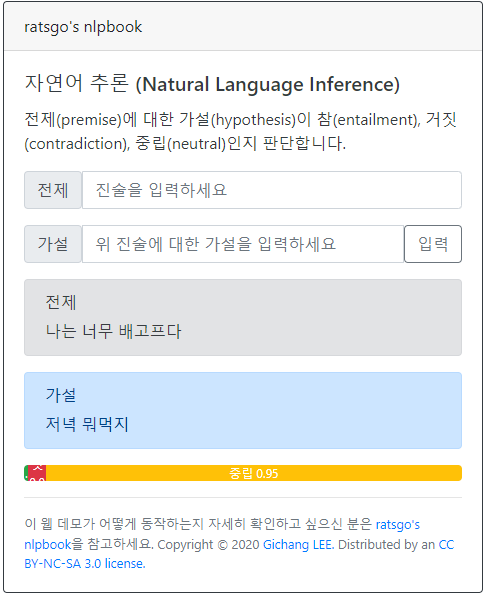